In [1]:
# Se importan las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
#pip install xgboost lightgbm

In [3]:
# Se importan las librerias para ML
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import train_test_split

In [4]:
# Se importa las tabla de review con el analisis de sentimiento hecho desde BigQuery 
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """SELECT * FROM `proyecto-levels-hh.ana_sent.ana_sent`"""
job = client.query(query)
df = job.to_dataframe()

In [5]:
# Se importa la tabla de metadatade los restaurantes desde BigQuery
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """SELECT * FROM `proyecto-levels-hh.metadata_ml.metadata_ml`"""
job = client.query(query)
df1 = job.to_dataframe()

In [6]:
# Se suman las columnas rating y sentiment_analysis para tomar solo una calificacion
df['rat_sa'] = df['rating'] + df['sentiment_analysis']


In [7]:
# Se borran las columnas que no se necesitan para el ML
eliminar = [0, 1, 2, 3, 5, 6, 7, 8, 9]
# Eliminar columnas
df.drop(df.columns[eliminar], axis=1, inplace=True)

In [8]:
# Se unen los 2 dataframes
df_join = pd.merge(df, df1, on='gmap_id', how='inner')

In [9]:
# Se realiza el conteo de reseñas y se crea una columna
cant_reseñas = df_join['gmap_id'].value_counts()
df_join['cant_reseñas'] = df_join['gmap_id'].map(cant_reseñas)

In [10]:
df_join.columns

Index(['gmap_id', 'rat_sa', 'name', 'state_name', 'Service_options__Delivery',
       'Amenities__Good_for_kids', 'Service_options__Takeout',
       'Atmosphere__Casual', 'Accessibility__Wheelchair_accessible_entrance',
       'Offerings__Comfort_food', 'Popular_for__Solo_dining',
       'Offerings__Quick_bite', 'Popular_for__Lunch',
       'Service_options__Dine_in', 'Popular_for__Dinner',
       'Dining_options__Dessert', 'Crowd__Groups', 'Dining_options__Lunch',
       'Offerings__Coffee', 'Payments__Debit_cards', 'Offerings__Small_plates',
       'Dining_options__Dinner', 'Offerings__Vegetarian_options',
       'Crowd__Tourists', 'general_1', 'cant_reseñas'],
      dtype='object')

In [11]:
# Se saca el promedio de calificaciones para cada restaurante
df_ml = df_join.groupby('gmap_id').agg({'rat_sa': 'mean', 'name': 'first', 'state_name': 'first',  'Service_options__Delivery': 'first', 'Amenities__Good_for_kids': 'first',
                                          'Service_options__Takeout': 'first', 'Atmosphere__Casual': 'first', 'Accessibility__Wheelchair_accessible_entrance': 'first',  
                                          'Offerings__Comfort_food': 'first', 'Popular_for__Solo_dining': 'first', 'Offerings__Quick_bite': 'first',
                                          'Popular_for__Lunch': 'first', 'Service_options__Dine_in': 'first', 'Popular_for__Dinner': 'first',
                                          'Dining_options__Dessert': 'first', 'Crowd__Groups': 'first', 'Dining_options__Lunch': 'first',
                                          'Offerings__Coffee': 'first', 'Payments__Debit_cards': 'first', 'Offerings__Small_plates': 'first',
                                          'Dining_options__Dinner': 'first', 'Offerings__Vegetarian_options': 'first', 'Crowd__Tourists': 'first',
                                          'general_1': 'first', 'cant_reseñas': 'first'}).reset_index()


In [12]:
proyecto = 'proyecto-levels-hh'
conjunto_datos = 'rating'
tabla_destino = 'ratings'

# Guarda el DataFrame en BigQuery
destination_table = f'{proyecto}.{conjunto_datos}.{tabla_destino}'
df_ml.to_gbq(destination_table, project_id=proyecto, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 3102.30it/s]


### Matriz de Correlacion

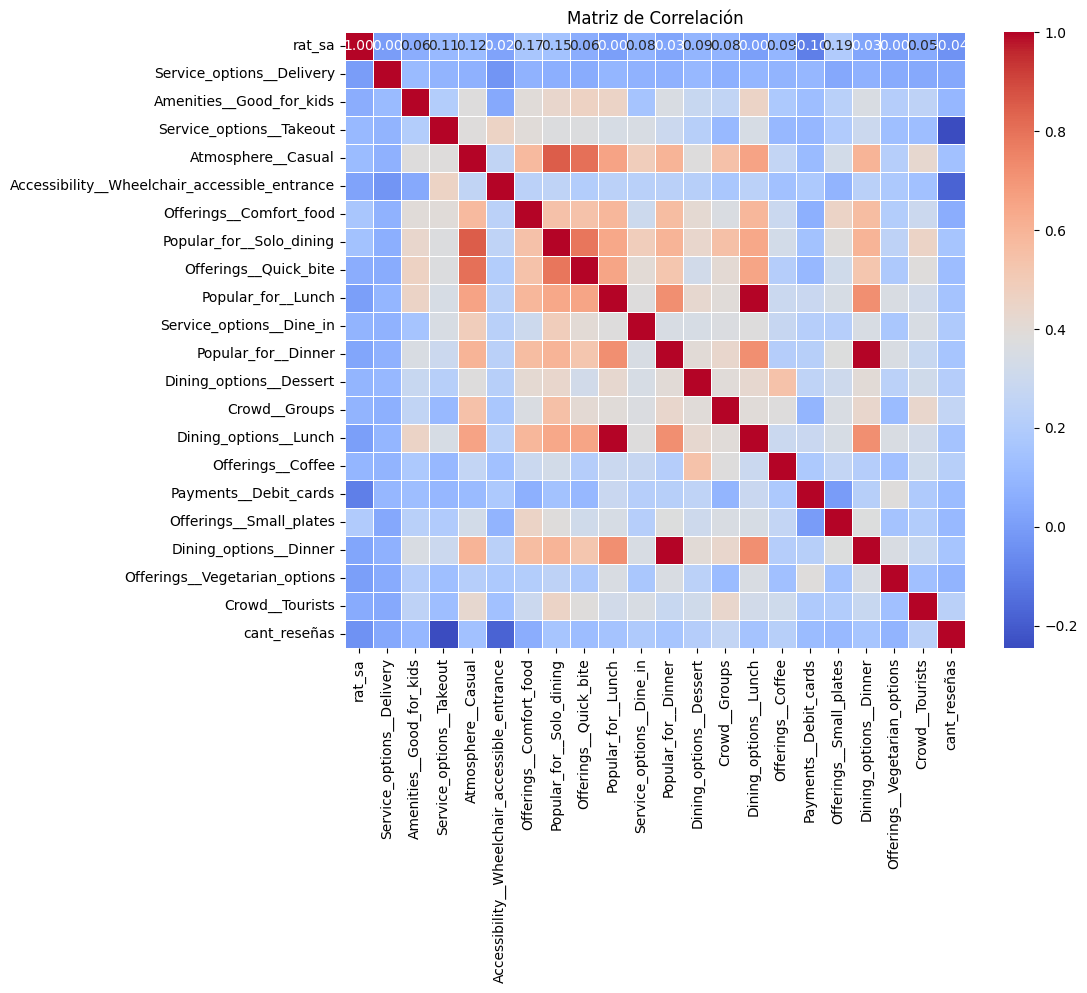

In [13]:
# Columnas numéricas y booleanas
df_ml_corr = df_ml.select_dtypes(include=['number', 'bool'])

# Matriz de correlación
matriz_correlacion = df_ml_corr.corr()

# Configura el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crea un mapa de calor con seaborn
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Ajusta la configuración de los ejes y muestra el gráfico
plt.title('Matriz de Correlación')
plt.show()

### Esto se tiene en cuenta para realizar predicciones
#### #df_ml['cant_reseñas'].sort_values() Los valores para la cantidad de reseñas varian entre 4 - 5061

In [14]:
# Normalizado
normalizar = df_ml[['cant_reseñas']]

# Se instancia MinMaxScaler
scaler = MinMaxScaler()

# Ajusta y transforma los datos
df_ml['cant_reseñas_nor'] = scaler.fit_transform(normalizar)

In [15]:
# Se borran las columnas que n o se necesitan
df_ml_0 = df_ml.drop(['gmap_id', 'name', 'cant_reseñas'], axis=1)

In [16]:
# Se verifica que no hay valores faltantes
df_ml_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127123 entries, 0 to 127122
Data columns (total 24 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   rat_sa                                         127123 non-null  Float64
 1   state_name                                     127123 non-null  object 
 2   Service_options__Delivery                      127123 non-null  boolean
 3   Amenities__Good_for_kids                       127123 non-null  boolean
 4   Service_options__Takeout                       127123 non-null  boolean
 5   Atmosphere__Casual                             127123 non-null  boolean
 6   Accessibility__Wheelchair_accessible_entrance  127123 non-null  boolean
 7   Offerings__Comfort_food                        127123 non-null  boolean
 8   Popular_for__Solo_dining                       127123 non-null  boolean
 9   Offerings__Quick_bite                

In [17]:
# Se preprocesan las columnas categoricas del dataframe
categorical_columns = ['general_1', 'state_name']
df_ml_1 = pd.get_dummies(df_ml_0, columns=categorical_columns)

In [18]:
# Se revisa que todo este bien
df_ml_1.head()

,rat_sa,Service_options__Delivery,Amenities__Good_for_kids,Service_options__Takeout,Atmosphere__Casual,Accessibility__Wheelchair_accessible_entrance,Offerings__Comfort_food,Popular_for__Solo_dining,Offerings__Quick_bite,Popular_for__Lunch,...,state_name_South Dakota,state_name_Tennessee,state_name_Texas,state_name_Utah,state_name_Vermont,state_name_Virginia,state_name_Washington,state_name_West Virginia,state_name_Wisconsin,state_name_Wyoming
0,5.090909,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4.656566,True,True,True,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,4.951681,True,True,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,4.361702,False,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,4.47619,True,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [19]:
# Se dividen los datos para realizar el entrenamiento y el test
y = df_ml_1.rat_sa
X = df_ml_1.drop(['rat_sa'], axis=1)

In [20]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Inicializar modelos
models = {"Ridge": Ridge(), "Lasso": Lasso(), "Random Forest": RandomForestRegressor(), "Decision Tree": DecisionTreeRegressor(),
           "ElasticNet": ElasticNet(), "GBR": GradientBoostingRegressor(), "XGB": XGBRegressor(), "LGBM": LGBMRegressor()}

for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en conjuntos de prueba
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calcular métricas MSE y MAE para el conjunto de entrenamiento
    mse_train = MSE(y_train, y_pred_train)
    mae_train = MAE(y_train, y_pred_train)
    
    # Calcular métricas MSE y MAE para el conjunto de prueba
    mse_test = MSE(y_test, y_pred_test)
    mae_test = MAE(y_test, y_pred_test)

    # Mostrar resultados
    print("{} Train Set - MSE: {:.4f}, MAE: {:.4f}".format(name, mse_train, mae_train))
    print("{} Test Set - MSE: {:.4f}, MAE: {:.4f}".format(name, mse_test, mae_test))
    print()

Ridge Train Set - MSE: 0.2464, MAE: 0.3783
Ridge Test Set - MSE: 0.2458, MAE: 0.3785

Lasso Train Set - MSE: 0.3015, MAE: 0.4269
Lasso Test Set - MSE: 0.2976, MAE: 0.4249

Random Forest Train Set - MSE: 0.0455, MAE: 0.1499
Random Forest Test Set - MSE: 0.2446, MAE: 0.3693

Decision Tree Train Set - MSE: 0.0157, MAE: 0.0277
Decision Tree Test Set - MSE: 0.4184, MAE: 0.4817

ElasticNet Train Set - MSE: 0.3015, MAE: 0.4269
ElasticNet Test Set - MSE: 0.2976, MAE: 0.4249

GBR Train Set - MSE: 0.2375, MAE: 0.3704
GBR Test Set - MSE: 0.2367, MAE: 0.3703

XGB Train Set - MSE: 0.2004, MAE: 0.3374
XGB Test Set - MSE: 0.2202, MAE: 0.3536

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number 

#### Se toma el algoritmo con mejor desempeño teniendo en cuenta el MAE y el sobreajuste

### XGBRegressor

In [21]:
# Inicializar el modelo XGBoost
xgb_model = XGBRegressor()

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Predecir en conjuntos de prueba
xgb_predictions = xgb_model.predict(X_test)

# Calcular métricas MAE y MSE para XGBoost
xgb_mae = MAE(y_test, xgb_predictions)
xgb_mse = MSE(y_test, xgb_predictions)

# Mostrar resultados para XGBoost
print("\nXGBoost - MAE: {:.4f}, MSE: {:.4f}".format(xgb_mae, xgb_mse))


XGBoost - MAE: 0.3536, MSE: 0.2202


In [22]:
# Obtener las importancias de las características
feature_importances = xgb_model.feature_importances_

# Crear un DataFrame con las características y sus importancias
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia en orden descendente
importance_xgb = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
top_20_features = importance_xgb.head(20)
print("\nTop 20 Features:")
print(top_20_features)


Top 20 Features:
                           Feature  Importance
46              general_1_Sandwich    0.077861
35           general_1_Gas station    0.070883
33             general_1_Fast food    0.067727
16         Offerings__Small_plates    0.055785
6         Popular_for__Solo_dining    0.043723
28               general_1_Chicken    0.040925
51  general_1_Veggie / Plant based    0.035569
45            general_1_Restaurant    0.029302
44                 general_1_Pizza    0.025797
24                 general_1_Asian    0.025092
8               Popular_for__Lunch    0.016814
72             state_name_Maryland    0.016750
15           Payments__Debit_cards    0.016212
27      general_1_Cafe / Breakfast    0.016004
2         Service_options__Takeout    0.015366
37     general_1_Healthy / Organic    0.014840
29                  general_1_Deli    0.014660
9         Service_options__Dine_in    0.012319
11         Dining_options__Dessert    0.012206
89               state_name_Oregon    0.01

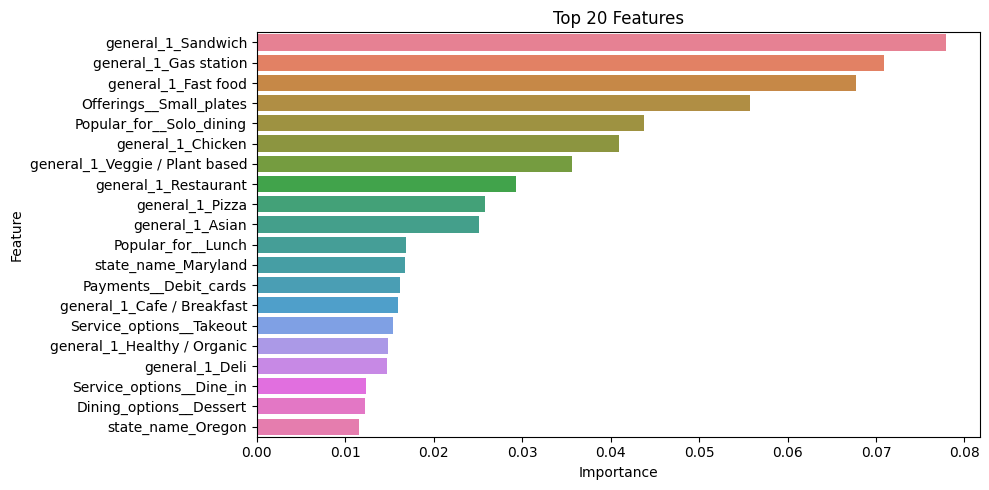

In [23]:
# Se grafican las principales características que más peso tienen en el modelo
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='husl')
plt.title('Top 20 Features')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Ajustar el diseño de la figura
plt.tight_layout()
plt.show()

#### Se hacen predicciones sobre todo el conjunto de datos 

In [24]:
# Predecir usando el modelo XGBoost ya entrenado
predictions = xgb_model.predict(X)

In [25]:
# Se arma la tabla con las predicciones y otros datos necesarios para el analisis
prediction = df_ml[['name', 'state_name', 'general_1', 'rat_sa']]
prediction = prediction.copy()
prediction['rating_predictivo'] = predictions

# Se cambia el nombre de algunas columnas
nombres_nuevos = {'general_1': 'category', 'rat_sa': 'rating_prom'}

# Cambiar los nombres de las columnas
prediction.rename(columns=nombres_nuevos, inplace=True)
prediction.head(2)

,name,state_name,category,rating_prom,rating_predictivo
0,Horizons,Florida,American,5.090909,4.785992
1,Bevi Seafood Company,Louisiana,Seafood,4.656566,4.782347


In [26]:
proyecto = 'proyecto-levels-hh'
conjunto_datos = 'prediction'
tabla_destino = 'predictions'

# Guarda el DataFrame en BigQuery
destination_table = f'{proyecto}.{conjunto_datos}.{tabla_destino}'
prediction.to_gbq(destination_table, project_id=proyecto, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 5940.94it/s]


In [27]:
predecir = pd.DataFrame(0, index=[0], columns=X.columns)
predecir.head()

,Service_options__Delivery,Amenities__Good_for_kids,Service_options__Takeout,Atmosphere__Casual,Accessibility__Wheelchair_accessible_entrance,Offerings__Comfort_food,Popular_for__Solo_dining,Offerings__Quick_bite,Popular_for__Lunch,Service_options__Dine_in,...,state_name_South Dakota,state_name_Tennessee,state_name_Texas,state_name_Utah,state_name_Vermont,state_name_Virginia,state_name_Washington,state_name_West Virginia,state_name_Wisconsin,state_name_Wyoming
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
predecir.loc[0, :] = 0
predecir

,Service_options__Delivery,Amenities__Good_for_kids,Service_options__Takeout,Atmosphere__Casual,Accessibility__Wheelchair_accessible_entrance,Offerings__Comfort_food,Popular_for__Solo_dining,Offerings__Quick_bite,Popular_for__Lunch,Service_options__Dine_in,...,state_name_South Dakota,state_name_Tennessee,state_name_Texas,state_name_Utah,state_name_Vermont,state_name_Virginia,state_name_Washington,state_name_West Virginia,state_name_Wisconsin,state_name_Wyoming
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
columnas_asignar = {'general_1_Sandwich': 1, 'general_1_Gas station': 1, 'general_1_Fast food': 1, 'Offerings__Small_plates': 1,
                'Popular_for__Solo_dining': 1, 'general_1_Chicken': 1, 'general_1_Veggie / Plant based': 0, 'general_1_Restaurant': 1,
                'general_1_Pizza': 1, 'general_1_Asian': 0, 'Popular_for__Lunch': 0, 'state_name_Maryland': 0,
        'Payments__Debit_cards': 1, 'general_1_Cafe / Breakfast': 0, 'Service_options__Takeout': 1, 'general_1_Healthy / Organic': 0,
        'general_1_Deli': 0, 'Service_options__Dine_in': 0, 'Dining_options__Dessert': 1, 'state_name_Oregon': 0,}

predecir.loc[0, columnas_asignar.keys()] = list(columnas_asignar.values())

In [30]:
prediccion = xgb_model.predict(predecir)
prediccion

array([4.53819], dtype=float32)